In [1]:
import numpy as np
import scipy.stats
import msprime
import pandas as pd
import allel
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def sim_2pops(diploid_size, split_time, seq_len, rec_rate, mut_rate):
    """simulate two populations that have diverged from a common ancestral population.
    Returns a tree sequence.
    @diploid_size = the population size of each population,
        also the size of the ancestral population
    @split_time = current populations split from the
        ancestral population this many generations ago
    @seq_len = length of the genome, units ~ base-pairs
    @rec_rate = recombination rate, units = rate per bp, per generation
    @mut_rate = mutation rate, units = rate per bp, per generation
    """
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=diploid_size)
    demography.add_population(name="B", initial_size=diploid_size)
    demography.add_population(name="C", initial_size=diploid_size)
    demography.add_population_split(time=split_time,
                                    derived=["A", "B"], ancestral="C")

    ts = msprime.sim_ancestry(
        samples={'A': diploid_size, 'B': diploid_size},  # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate,
        model='dtwf',
    )

    ts = msprime.sim_mutations(
        ts,
        rate=mut_rate,
        discrete_genome=False,
        start_time=split_time,
        )

    return ts


def sample_individuals(haploid_indexes, n, replace):
    """
    return the (haploid) indexes that correspond to
    taking n diploid samples from the supplied haploid indexes
    @haploid_indexes = contiguous indexes for haploids
        should be from a single population.
    @n = the number of diploid indiviudals to take.
    """

    # ensure the haploid indexes are consecutive
    # diff = np.diff(haploid_indexes)
    # assert np.sum(diff == 1) == (len(haploid_indexes)-1)

    ind_indexes = haploid_indexes[::2]
    ind_samples = np.sort(np.random.choice(ind_indexes, n, replace=replace))
    haploid_samples = np.zeros(len(ind_samples)*2, dtype='int')
    haploid_samples[0::2] = ind_samples
    haploid_samples[1::2] = ind_samples+1
    return haploid_samples
    
    
def observe(ts, num_inds, max_sites, num_pop):
    """oberserve num_inds diploids from each population
    simplify the ts, removing non-variable sites across those individuals
    @ts = tree-sequence
    @num_inds = number of diploids to sample from each population
    @max_sites = retain at most max_sites, from among variable sites
    @num_pop = number of population
    """
    pop = [ts.samples(population=i) for i in range(num_pop)]
    pop_inds = [sample_individuals(i, num_inds, replace=False) for i in pop]
    all_inds = np.concatenate(pop_inds)
    obs_ts = ts.simplify(samples=all_inds, filter_sites=False)

    if obs_ts.num_sites > max_sites:
        all_sites = np.arange(len(obs_ts.sites()))
        sites_keep = np.random.choice(all_sites, max_sites, replace=False)
        sites_remove = np.setdiff1d(all_sites, sites_keep)
        obs_ts = obs_ts.delete_sites(sites_remove)

    return obs_ts

In [3]:
def get_fst_general(ts, sites_index, popA_samples, popB_samples):
    """returns Hudson's Fst
    This function is general in the sense that all of:
      (popA_samples, popB_samples) may have duplicates.
    
    @popA_samples = the samples from the first population to be used
    @popB_samples = the samples from the second population to be used
    """
    ga = allel.GenotypeArray(ts.genotype_matrix().reshape(ts.num_sites, ts.num_samples, 1), dtype='i1')
    # count alleles within each population at the selected sites and ind
    ac1 = ga[sites_index][:, popA_samples, :].count_alleles()
    ac2 = ga[sites_index][:, popB_samples, :].count_alleles()
    # calculate Hudson's Fst (weighted)
    num, den = allel.hudson_fst(ac1, ac2)
    return np.sum(num) / np.sum(den)

In [4]:
def get_num_den_fst(ts):
    """ only to be used for resampling sites"""
    ga = allel.GenotypeArray(ts.genotype_matrix().reshape(ts.num_sites, ts.num_samples, 1), dtype='i1')
    num, den = allel.hudson_fst(
        ga[:, ts.samples(population=0), :].count_alleles(),
        ga[:, ts.samples(population=1), :].count_alleles()
    )    
    return(num, den)

def bootstrap_sites_fst(ts, num_boot=500):
    """Calculate Fst for bootstrap of sites.
    @num_boot = number of bootstrap re-samplings
    """
    
    num, den = get_num_den_fst(ts)

    weights = np.random.multinomial(
        n=ts.num_sites,
        pvals=np.ones(ts.num_sites) / ts.num_sites,
        size=num_boot
    )
    return (num * weights).sum(1) / (den * weights).sum(1)

def jackknife_sites_fst(ts):
    """Calculate Fst for jackknife of sites.
    """
    num, den = get_num_den_fst(ts)
    num_sum, den_sum = num.sum(), den.sum()
    return (num_sum - num) / (den_sum - den)

def jackknife_inds_fst(ts):
    sample_inputs = [(np.delete(ts.samples(0), [i, i + 1]), ts.samples(1))
          for i in range(0, len(ts.samples(0)), 2)] + \
         [(np.delete(ts.samples(1), [i, i + 1]), ts.samples(0))
          for i in range(0, len(ts.samples(1)), 2)]
    res = [get_fst_general(obs_ts, np.arange(obs_ts.num_sites), pA, pB) for pA, pB in sample_inputs]
    return(np.array(res))

In [5]:
def bt_standard(bt, confidence, obs_value):
    """ calculate the standard normal confidence interval of the bootstrap values
    return the lower and upper bound
    @bt: bootstrap values
    @confidence: confidence level
    @obs_value: estimated value of the observation sample
    """
    z_score = abs(norm.ppf((1 - confidence) / 2))
    upper = obs_value + z_score * np.std(bt, ddof=1)  # change degree of freedom
    lower = obs_value - z_score * np.std(bt, ddof=1)
    assert upper > lower
    return lower, upper


def jk_delete_one(jk, confidence, obs_value):
    """calculate the standard normal confidence interval of the jackknife values (delete one methods)
    return the lower and upper bound
    @jk: jackknife values
    @confidence interval: confidence level
    @obs_value: estimated value of the observation sample
    """
    n = len(jk)
    # variance of the jk values
    var = (n - 1) * np.sum(np.square(jk - np.mean(jk))) / n
    z_score = abs(norm.ppf((1 - confidence) / 2))

    upper = obs_value + z_score * np.sqrt(var)
    lower = obs_value - z_score * np.sqrt(var)
    assert upper > lower
    return lower, upper

In [27]:
# simulation of the entire demographic history
pop_ts = sim_2pops(
    diploid_size=1000,
    seq_len=1e9,
    rec_rate=1e-8,
    mut_rate=1e-8,
    split_time=100
)
pop_ts

pop: 0.04870
obs: 0.04566
obs: 0.04467
obs: 0.04636
obs: 0.04480
obs: 0.05448
obs: 0.04443
obs: 0.04595
obs: 0.05164
obs: 0.04907
obs: 0.05645
obs: 0.04658
obs: 0.04315
obs: 0.04268
obs: 0.05121
obs: 0.06503
obs: 0.04622
obs: 0.04777
obs: 0.05137
obs: 0.05148
obs: 0.04752
obs: 0.05158
obs: 0.04535
obs: 0.04588
obs: 0.04466
obs: 0.04026
obs: 0.04612
obs: 0.04583
obs: 0.04002
obs: 0.05112
obs: 0.04883
obs: 0.05201
obs: 0.05271
obs: 0.04392
obs: 0.04193
obs: 0.04345
obs: 0.06130
obs: 0.04497
obs: 0.05521
obs: 0.05406
obs: 0.04384


Text(0.5, 0.98, 'max sites: 500')

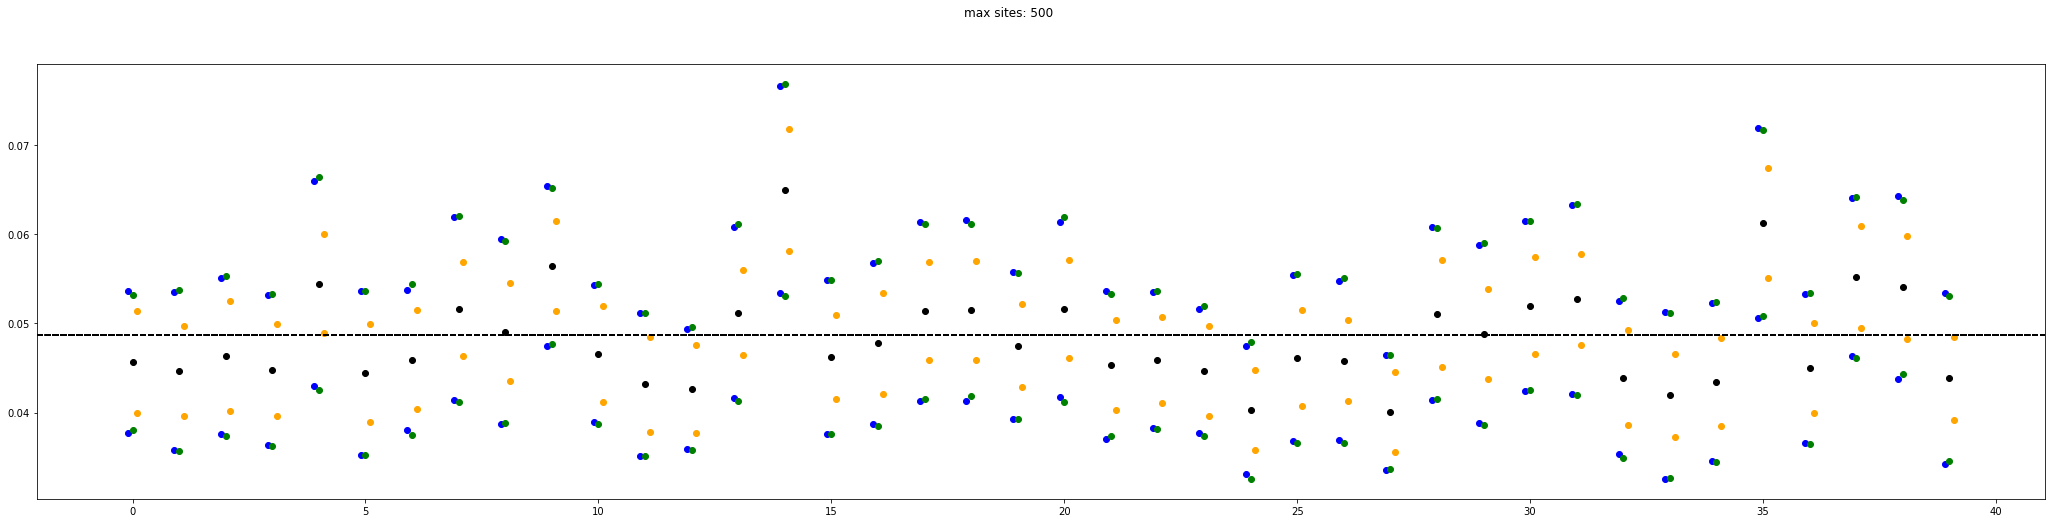

In [32]:
nrep = 40
ci_interval = 0.95
max_sites = 500

pop_fst = get_fst_general(pop_ts, np.arange(pop_ts.num_sites), pop_ts.samples(0), pop_ts.samples(1))
print(f"pop: {pop_fst:0.5f}")

fig, ax = plt.subplots(figsize=(36,8))
for x in range(nrep):
    obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=max_sites, num_pop=2)
    obs_fst = get_fst_general(obs_ts, np.arange(obs_ts.num_sites), obs_ts.samples(0), obs_ts.samples(1))
    print(f"obs: {obs_fst:0.5f}")
    # resample sites
    bt_site_vals = bootstrap_sites_fst(obs_ts)
    jk_site_vals = jackknife_sites_fst(obs_ts)
    # resamples inds
    jk_ind_vals = jackknife_inds_fst(obs_ts)
    
    # calculate cis
    bt_site_ci = bt_standard(bt_site_vals, ci_interval, obs_fst)
    jk_site_ci = jk_delete_one(jk_site_vals, ci_interval, obs_fst)
    jk_ind_ci = jk_delete_one(jk_ind_vals, ci_interval, obs_fst)
    
    ax.axhline(y=pop_fst, c = 'black', ls = '--')
    ax.scatter(x, obs_fst, c = 'black')
    ax.scatter([x-.1]*2, bt_site_ci, c='blue', label = 'bt_site')
    ax.scatter([x]*2, jk_site_ci, c='green', label = 'jk_site')
    ax.scatter([x+.1]*2, jk_ind_ci, c='orange', label = 'jk_ind')
plt.suptitle(f'max sites: {max_sites}')

pop: 0.04870
obs: 0.04819
obs: 0.04610
obs: 0.04914
obs: 0.04874
obs: 0.04989
obs: 0.04768
obs: 0.04788
obs: 0.04745
obs: 0.04672
obs: 0.04951
obs: 0.04900
obs: 0.04628
obs: 0.04774
obs: 0.04988
obs: 0.04819
obs: 0.04848
obs: 0.04838
obs: 0.05151
obs: 0.04905
obs: 0.04606
obs: 0.05073
obs: 0.05048
obs: 0.04835
obs: 0.04841
obs: 0.05173
obs: 0.04988
obs: 0.04706
obs: 0.04755
obs: 0.04711
obs: 0.04874
obs: 0.04917
obs: 0.04888
obs: 0.04999
obs: 0.04833
obs: 0.04933
obs: 0.05055
obs: 0.04800
obs: 0.05017
obs: 0.04862
obs: 0.04824


Text(0.5, 0.98, 'max sites: 5000')

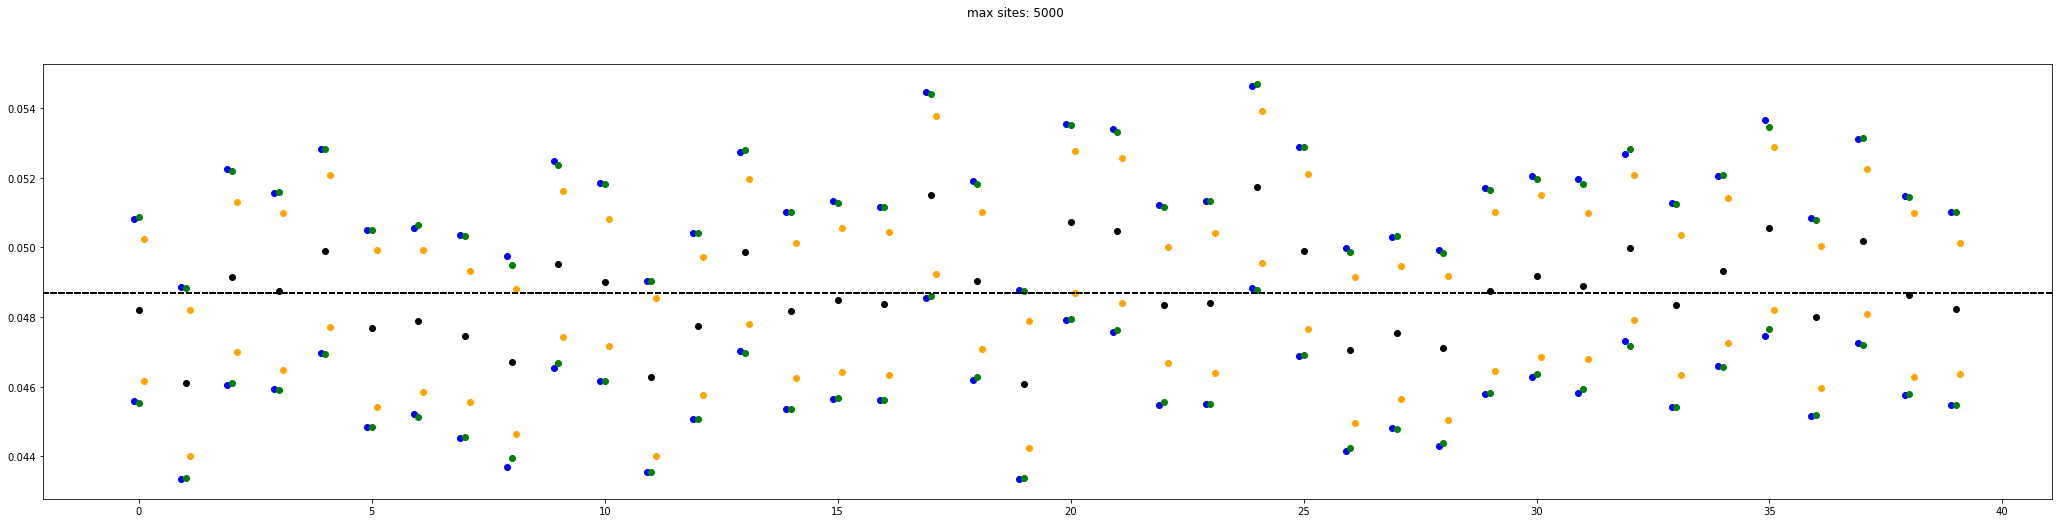

In [33]:
nrep = 40
ci_interval = 0.95
max_sites = 5000

pop_fst = get_fst_general(pop_ts, np.arange(pop_ts.num_sites), pop_ts.samples(0), pop_ts.samples(1))
print(f"pop: {pop_fst:0.5f}")

fig, ax = plt.subplots(figsize=(36,8))
for x in range(nrep):
    obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=max_sites, num_pop=2)
    obs_fst = get_fst_general(obs_ts, np.arange(obs_ts.num_sites), obs_ts.samples(0), obs_ts.samples(1))
    print(f"obs: {obs_fst:0.5f}")
    # resample sites
    bt_site_vals = bootstrap_sites_fst(obs_ts)
    jk_site_vals = jackknife_sites_fst(obs_ts)
    # resamples inds
    jk_ind_vals = jackknife_inds_fst(obs_ts)
    
    # calculate cis
    bt_site_ci = bt_standard(bt_site_vals, ci_interval, obs_fst)
    jk_site_ci = jk_delete_one(jk_site_vals, ci_interval, obs_fst)
    jk_ind_ci = jk_delete_one(jk_ind_vals, ci_interval, obs_fst)
    
    ax.axhline(y=pop_fst, c = 'black', ls = '--')
    ax.scatter(x, obs_fst, c = 'black')
    ax.scatter([x-.1]*2, bt_site_ci, c='blue', label = 'bt_site')
    ax.scatter([x]*2, jk_site_ci, c='green', label = 'jk_site')
    ax.scatter([x+.1]*2, jk_ind_ci, c='orange', label = 'jk_ind')
plt.suptitle(f'max sites: {max_sites}')

pop: 0.04870
obs: 0.04835
obs: 0.04957
obs: 0.04738
obs: 0.04865
obs: 0.04902
obs: 0.04806
obs: 0.04837
obs: 0.04905
obs: 0.04755
obs: 0.04915
obs: 0.04704
obs: 0.04774
obs: 0.04979
obs: 0.04881
obs: 0.04872
obs: 0.04813
obs: 0.04886
obs: 0.04915
obs: 0.04921
obs: 0.04882
obs: 0.04868
obs: 0.04915
obs: 0.04872
obs: 0.05003
obs: 0.04845
obs: 0.04764
obs: 0.04835
obs: 0.04832
obs: 0.04882
obs: 0.04778
obs: 0.05006
obs: 0.04861
obs: 0.04833
obs: 0.04742
obs: 0.04928
obs: 0.04775
obs: 0.04891
obs: 0.04872
obs: 0.04766
obs: 0.04814


Text(0.5, 0.98, 'max sites: 50000')

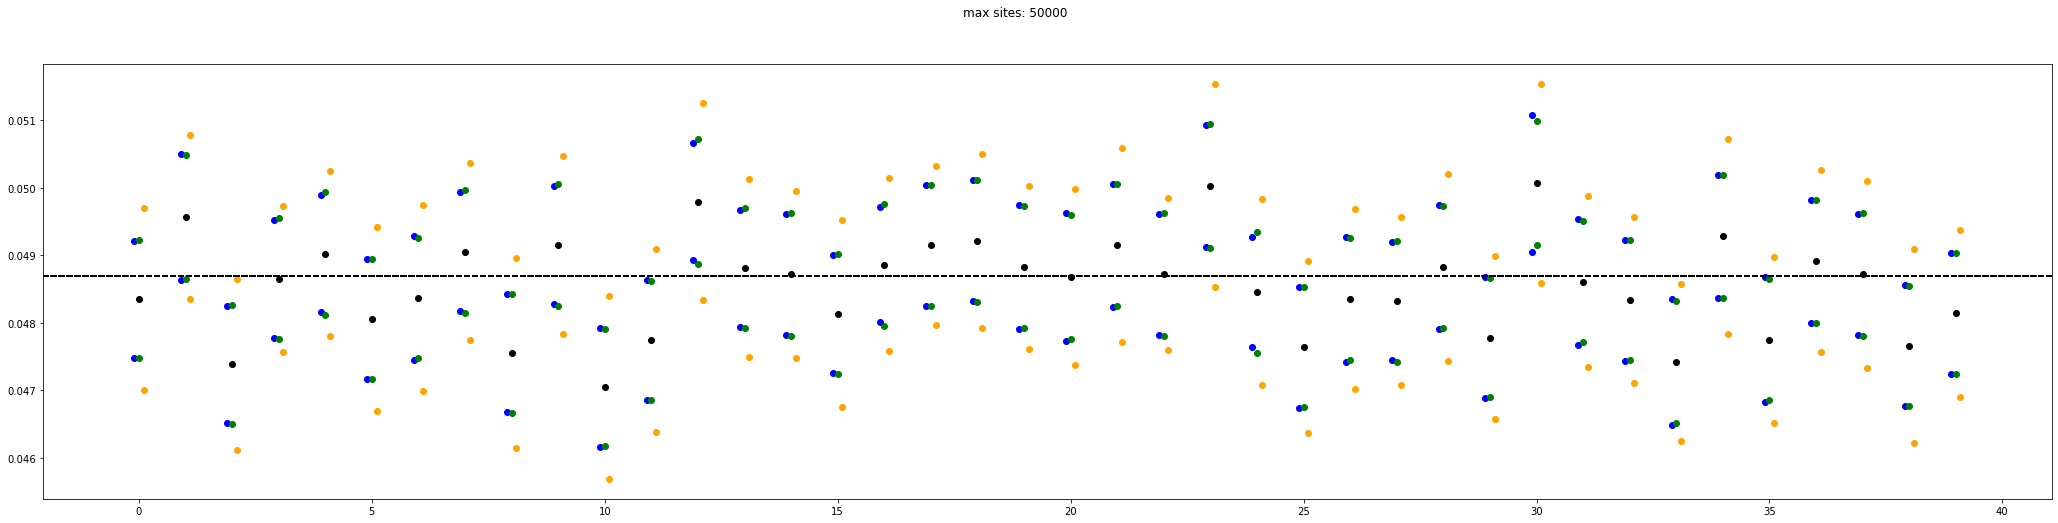

In [34]:
nrep = 40
ci_interval = 0.95
max_sites = 50000

pop_fst = get_fst_general(pop_ts, np.arange(pop_ts.num_sites), pop_ts.samples(0), pop_ts.samples(1))
print(f"pop: {pop_fst:0.5f}")

fig, ax = plt.subplots(figsize=(36,8))
for x in range(nrep):
    obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=max_sites, num_pop=2)
    obs_fst = get_fst_general(obs_ts, np.arange(obs_ts.num_sites), obs_ts.samples(0), obs_ts.samples(1))
    print(f"obs: {obs_fst:0.5f}")
    # resample sites
    bt_site_vals = bootstrap_sites_fst(obs_ts)
    jk_site_vals = jackknife_sites_fst(obs_ts)
    # resamples inds
    jk_ind_vals = jackknife_inds_fst(obs_ts)
    
    # calculate cis
    bt_site_ci = bt_standard(bt_site_vals, ci_interval, obs_fst)
    jk_site_ci = jk_delete_one(jk_site_vals, ci_interval, obs_fst)
    jk_ind_ci = jk_delete_one(jk_ind_vals, ci_interval, obs_fst)
    
    ax.axhline(y=pop_fst, c = 'black', ls = '--')
    ax.scatter(x, obs_fst, c = 'black')
    ax.scatter([x-.1]*2, bt_site_ci, c='blue', label = 'bt_site')
    ax.scatter([x]*2, jk_site_ci, c='green', label = 'jk_site')
    ax.scatter([x+.1]*2, jk_ind_ci, c='orange', label = 'jk_ind')
plt.suptitle(f'max sites: {max_sites}')